In [1]:
:e ImportQualifiedPost
:e FlexibleContexts
:e BlockArguments
:e TupleSections
:e FlexibleContexts
:e OverloadedStrings
:e LambdaCase

import Control.Arrow (first)
import Data.Text (pack)
import Control.Monad
import Numeric.Log

import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Enumerator
import Control.Monad.Bayes.Weighted
import Control.Monad.Bayes.Sampler
import Control.Monad.Bayes.Integrator

:l Plotting.hs


# Introduction to Monad-Bayes

This serves as an interactive alternative to [the user guide](https://monad-bayes.netlify.app/probprog.html). This isn't intended as a tutorial to Haskell, but if you're familiar with probabilistic programming, the general flow of the code should look familiar.

To get a sense of how probabilistic programming with monad-bayes works, consider the following:

In [3]:
model :: MonadInfer m => Double -> m Double
model observation = do
    mean <- uniformD [-1, 0, 1]
    factor (normalPdf mean 1 observation)
    return mean

The idea of monad-bayes, and probabilistic programming languages in general is to define distributions as programs. `model` corresponds to the distribution that you would express mathematically as:

$$ P(m | o) = \frac{P(m)P(o|m)}{P(o)} = \frac{1/3 * \mathbb{N}(o; m, 1)}{\sum_{m' \in \{-1,0,1\}} 1/3 * \mathbb{N}(o; m', 1) } $$

As a program, you can think of `model` as doing the following:

- first draw from the prior over possible values of `mean` (that's the line `mean <- uniformD [-1, 0, 1]`)
- then score a draw higher according to the likelihood placed on `observation` (the argument to `model`) by a normal with $\mu$=`mean`

- then return the `mean`

To orient you on the relationship between the mathematical view of a distribution and the programming one, here are some notes:

- a distribution over values of type `a` has type `MonadInfer m => m a`
- a joint distribution over values of types `a` and `b` is a distribution over a tuple: `MonadInfer m => m (a, b)`
- a conditional distribution over values of type `a` conditioned on values of type `b` is a function into a distribution: 
    `MonadInfer m => b -> m a`



For example, if the value observed is $0.3$, then we can calculate the distribution over the mean:



In [4]:
inferredDistribution = enumerate $ model 0.3
inferredDistribution

[(0.0,0.44090549839518783),(1.0,0.36098289073731515),(-1.0,0.198111610867497)]

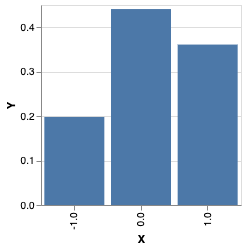

In [5]:
plotVega (first (pack . show) <$> inferredDistribution)

To produce this plot, we performed *inference*, to obtain the exact form of the distribution represented by `model`. Because the only random variable in `model` had a support that was small and discrete (the set $\{-1, 0, 1\}$), performing this inference exactly was straightforward.

`enumerate` is an exact inference method offered by monad-bayes targeted as discrete distributions.

You are encouraged to change `model` in a number of ways and observe how the results change:
- try changing the prior (currently `uniformD [-1, 0, 1]`)
- try changing the score (currently `factor (normalPdf mean 1 observation)`)
- try changing the types of the observation and latent variable (i.e. `mean`)

# Distributions as programs

If you are familiar with Haskell, then it should be clear that the class of distributions you can express in this way is very broad, since we have monadic control flow. For example, you could build:

In [4]:
lengthDist :: MonadInfer m => Double -> m Int
lengthDist observation = do
    means <- replicateM 3 (model observation)
    return (length $ filter (>=1) means)

# Exact inference for continuous distributions

`enumerate` only works for discrete random variables (like categorical or bernoulli distributions).

For continuous distributions, there is almost a (near) exact inference algorithm, which performs numerical integration. It is defined in `Control.Monad.Bayes.Integrator`, which also provides `histogram`:


Given an observation, this is the probability on how many (out of 3) independent draws from the posterior of the model conditioned on the observation will be greater or equal to 1. Consider the hassle of defining this with an equation, and you'll see why probabilistic programming is appealing as a way of accelerating modelling and inference.

In [7]:
enumerate $ lengthDist 0.5

[(1,0.4228030765220977),(2,0.3090938161626379),(0,0.19278121201287118),(3,7.532189530239404e-2)]

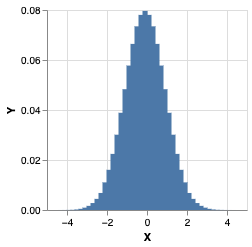

In [8]:
import Data.List
import Data.Ord
import qualified Data.Text as T

plotVega $ histogram 45 0.2 (normal 0 1)

This will work for any distribution in principle, but in practice it is unfeasibly slow for complex distributions. That said, quite a few interesting distributions can be expressed, like this mixture of Gaussians:

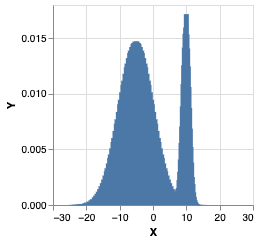

In [21]:
model2 = do
    p <- bernoulli 0.2
    if p then normal 10 1 else normal (-5) 5

plotVega $ histogram 250 0.2 model2

Or this normal distribution restricted to the positive reals (i.e. $p(x) \propto N(x;0,4)\cdot I[x>0]$)

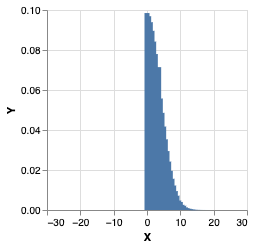

In [30]:
model3 :: MonadInfer m => m Double
model3 = do

    x <- normal 0 4
    condition (x > 0)
    return x

plotVega $ histogram 100 0.5 model3

Or this unusual distribution with $p(x) \propto N(x;0,4)*e^{sin(x)}$:

Line 9: Redundant bracket
Found:
(model4)
Why not:
model4

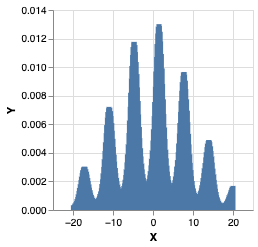

In [77]:

model4 :: MonadInfer m => m Double
model4 = do

    x <- normal 0 10
    factor $ Exp (sin x )
    return x

plotVega $ histogram 400 0.1 (model4)



We can also plot the CDF, as in:

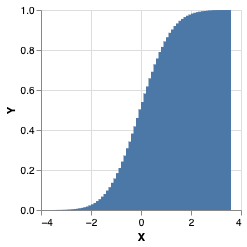

In [78]:
plotVega $ plotCdf 70 0.1 (normal 0 1)

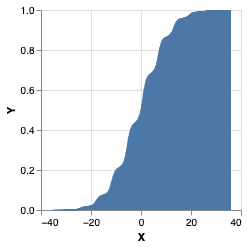

In [81]:
plotVega $ plotCdf 700 0.1 $ normalize model4

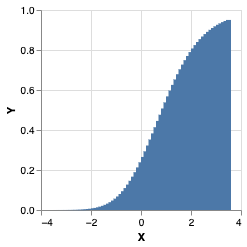

In [80]:
plotVega $ plotCdf 70 0.1 (normal 0 1 + gamma 1 1)

# Expressing distributions with code

If you are familiar with Haskell, then it should be clear that the class of distributions you can express by writing probabilistic programs is very broad, since `m` is a monad. For example, you can use `fmap` to apply a function to the support of the distribution, like:

In [82]:
mapped :: MonadInfer m => m Bool
mapped = fmap (> 0) (model 0.5)

And you can use the standard set of monadic and applicative combinators, like `when`, `filterM` or `replicateM`:

In [10]:
lengthDist :: MonadInfer m => Double -> m Int
lengthDist observation = do
    means <- replicateM 3 (model observation)
    return (length $ filter (>=1) means)

Given an observation, this is the probability on how many (out of 3) independent draws from the posterior of the model conditioned on the observation will be greater or equal to 1. Consider the hassle of defining this with an equation, and you'll see why probabilistic programming is appealing as a way of accelerating modelling and inference.

In [11]:
enumerate $ lengthDist 0.5

[(1,0.4228030765220977),(2,0.3090938161626379),(0,0.19278121201287118),(3,7.532189530239404e-2)]

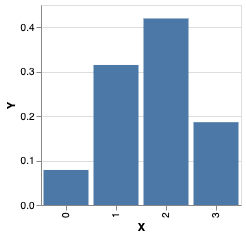

In [12]:
plotVega $ fmap (first (pack . show)) $ enumerate $ lengthDist 0.99

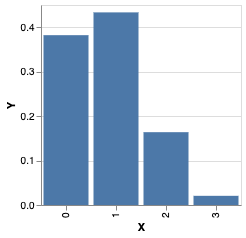

In [13]:
plotVega $ fmap (first (pack . show)) $ enumerate $ lengthDist 0.001

Exact sampling is pretty limited. For models with continuous random variables, or large discrete ones, it is a no-go. 

The broader goal is to be able to define your distribution of interest, like `model`, and then apply different inference technique, usually approximate, to it. This is what monad-bayes (and other probabilistic programming languages) enable. See the following tutorials for details.